# Predict Question Type

## 1. Business Problem and Understanding

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
np.random.seed(42)
random.seed(42)
import nltk
from nltk import pos_tag, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import itertools
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import classification_report,f1_score, RocCurveDisplay, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
# import warnings
# warnings.filterwarnings("ignore")

## 2. Data Understanding

Our target will the be `qtype` or question type and we will try to match the `Question` column to be able to advice on appropriate next steps accoridng to the type of question being asked.

In [2]:
# Load dataset

df = pd.read_csv('train.csv')
df.head()

,qtype,Question,Answer
0,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,LCMV infections can occur after exposure to fr...
1,symptoms,What are the symptoms of Lymphocytic Choriomen...,LCMV is most commonly recognized as causing ne...
2,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,Individuals of all ages who come into contact ...
3,exams and tests,How to diagnose Lymphocytic Choriomeningitis (...,"During the first phase of the disease, the mos..."
4,treatment,What are the treatments for Lymphocytic Chorio...,"Aseptic meningitis, encephalitis, or meningoen..."


No missingness to take care of.

In [3]:
df.isna().sum()

qtype       0
Question    0
Answer      0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16407 entries, 0 to 16406
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   qtype     16407 non-null  object
 1   Question  16407 non-null  object
 2   Answer    16407 non-null  object
dtypes: object(3)
memory usage: 384.7+ KB


Looks like our questions address inquiries about specific diseases. This can be applied to help both patients and medical professionals in training with future enhancements to the model.

In [72]:
print(df['Question'][3])
print(df['Question'][22])
print(df['Question'][145])

How to diagnose Lymphocytic Choriomeningitis (LCM) ?
what else can be done to prevent these diseases for Marine Toxins ?
Who is at risk for Parasites - Enterobiasis (also known as Pinworm Infection)? ?


## 3. Data Exploration

### Target Variable `qtype`

Since we have some question types that have very few instances, we will have to drop that row before spliting our data if we want to keep class proportions. We will also have to consider our class imbalance when creating our models.

We can also use `LabelEncoder` to transform this variable before the train test split if we choose.

qtype
information        4535
symptoms           2748
treatment          2442
inheritance        1446
frequency          1120
genetic changes    1087
causes              727
exams and tests     653
research            395
outlook             361
susceptibility      324
considerations      235
prevention          210
stages               77
complications        46
support groups        1
Name: count, dtype: int64


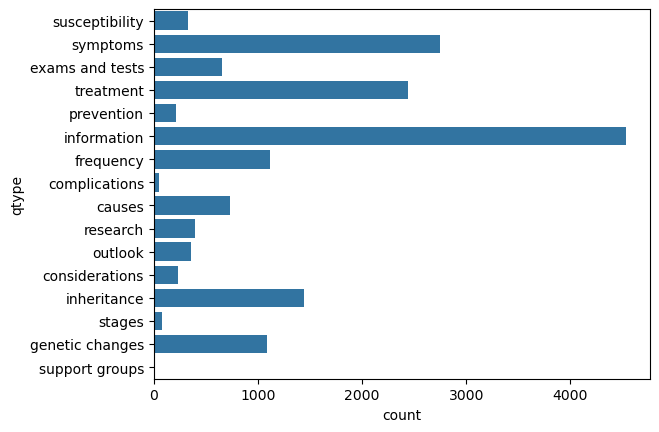

In [5]:
print(df['qtype'].value_counts())
sns.countplot(df['qtype']);

### Preprocess Analysis

First, we should take a look at what the word frequency looks like before cleaning our data for things like stopwords and punctuation. It looks like we have a lot of stop words as well as other words that typically would be meaningful but are not in our medical context.

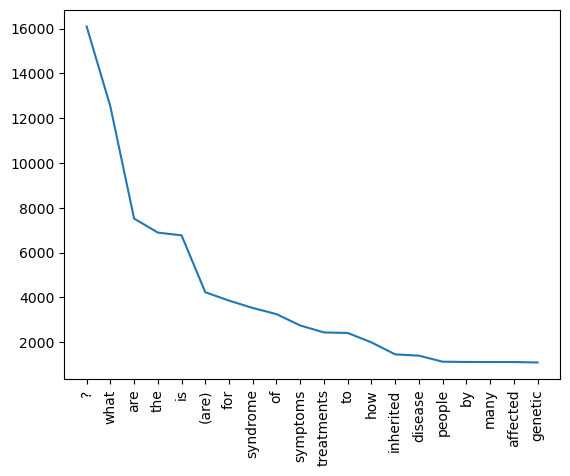

In [6]:
# Unprocessed corpus for Question

corpus = []

for record in df['Question']:
    corpus.extend(record.lower().split(' '))

# Create series
top20words = FreqDist(corpus).most_common(20)
series = pd.Series(dict(top20words))

# Plot series
sns.lineplot(series)
plt.xticks(rotation=90);

Transformer for easy text preprocessing.

In [76]:
class TextPreprocessor(BaseEstimator, TransformerMixin):

    # BaseEstimator and TransformerMixin are parents enable us to use this class in a pipeline
    # Could have made this into a function and would have to use FunctionTransformer to use in a pipeline
    
    def __init__(self):
        
        #define attributes to store if text preprocessing requires fitting from data
        pass
    
    def fit(self, data, y = 0):
        # this is where you would fit things like corpus specific stopwords
        # fit probable bigrams with bigram model in here
        
        # save as parameters of Text preprocessor
        
        return self
    
    def transform(self, data, y = 0):
        fully_normalized_corpus = data.apply(self.process_doc)
        
        return fully_normalized_corpus
        
    
    def process_doc(self, doc):

        #initialize lemmatizer
        wnl = WordNetLemmatizer()
        stop_words = stopwords.words('english')
        
        # helper function to change nltk's part of speech tagging to a wordnet format.
        def pos_tagger(nltk_tag):
            if nltk_tag.startswith('J'):
                return wordnet.ADJ
            elif nltk_tag.startswith('V'):
                return wordnet.VERB
            elif nltk_tag.startswith('N'):
                return wordnet.NOUN
            elif nltk_tag.startswith('R'):
                return wordnet.ADV
            else:         
                return None


        # remove stop words and punctuations, then lower case
        doc_norm = [tok.lower() for tok in word_tokenize(doc) if ((tok.isalpha()) & (tok not in stop_words)) ]

        #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize

        # creates list of tuples with tokens and POS tags in wordnet format
        wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(doc_norm))) 
        doc_norm = [wnl.lemmatize(token, pos) for token, pos in wordnet_tagged if pos is not None]

        return " ".join(doc_norm)

## 4. Data Preperation

Before we split our data, we have to first drop the class with only one record since this interferes with our stratifying the split to keep class distributions consistant.

In [8]:
# Identify index
index_drop = df[df['qtype']=='support groups'].index[0]

df_new = df.copy().drop(index_drop)

X = df_new['Question']
y = df_new['qtype']

# Label encode the target
le = LabelEncoder()
y = le.fit_transform(df_new['qtype'])

# Split train/test data
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

As our base model, we will try a `MultinomialNB` model as it is great for text classification problems.

In [77]:
# Create preprocess pipeline

prc_steps = [('txtproc',TextPreprocessor()),
             ('tfid',TfidfVectorizer(min_df=.05,max_df=.95)),
             ('model', MultinomialNB())]

init_pipe = Pipeline(steps = prc_steps)

init_pipe.fit(X_train,y_train)

Pipeline(steps=[('txtproc', TextPreprocessor()),
                ('tfid', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('model', MultinomialNB())])

In [78]:
# Get the feature names from the vectorized X
feat_names = init_pipe['tfid'].get_feature_names_out()

X_train_trans = init_pipe.named_steps['tfid'].transform(X_train)

pd.DataFrame(X_train_trans.toarray(),columns=feat_names)

,affect,be,change,deficiency,disease,genetic,inherit,many,people,relate,symptoms,syndrome,treatments,type
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.63792,0.636277,0.0,0.000000,0.433831,0.000000,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,1.000000,0.000000,0.000000,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,1.000000,0.000000,0.000000,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12299,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.743635,0.668586,0.000000,0.0
12300,0.0,0.0,0.0,0.818952,0.0,0.0,0.0,0.00000,0.000000,0.0,0.573863,0.000000,0.000000,0.0
12301,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.652746,0.757577,0.0
12302,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,1.000000,0.0


Let's quickly look at our distribution of selected features.

In [79]:
feature_counts = np.sum(X_train_trans.toarray(), axis=0)

# Print the feature counts
print("Feature Distribution:")
for feature, count in zip(feat_names, feature_counts):
    print(f"{feature}: {count}")

Feature Distribution:
affect: 0.0
be: 6.0
change: 1.0
deficiency: 528.7611560213874
disease: 932.5112691033103
genetic: 722.8049375451345
inherit: 0.0
many: 549.93676035932
people: 555.4542073344257
relate: 0.0
symptoms: 1748.9132361258712
syndrome: 2098.8126196054563
treatments: 1595.2488492592743
type: 543.1402864608959


## 5. Naive Bayes
Lets check our baseline metrics then move on to cross validation and hyperparameter tuning our base model.

Since we have a class imbalance, we will mostly be focusing on a weighted f1 score. Looking at our classification report our weighted average for f1 looks pretty good. Our precision and recall look pretty great also as a start.

In [12]:
# Baseline score

print('Train Score:', classification_report(y_train,init_pipe.predict(X_train),zero_division=1))

Train Score:               precision    recall  f1-score   support

           0       0.99      1.00      0.99       545
           1       1.00      0.00      0.00        35
           2       1.00      0.00      0.00       176
           3       1.00      1.00      1.00       490
           4       1.00      1.00      1.00       840
           5       1.00      1.00      1.00       815
           6       0.73      1.00      0.84      3401
           7       0.99      1.00      1.00      1084
           8       1.00      0.00      0.00       271
           9       1.00      0.00      0.00       158
          10       1.00      0.00      0.01       296
          11       1.00      0.00      0.00        58
          12       1.00      0.00      0.00       243
          13       1.00      1.00      1.00      2061
          14       1.00      1.00      1.00      1831

    accuracy                           0.90     12304
   macro avg       0.98      0.53      0.52     12304
weighted avg 

Let's now conduct some cross validation and hyperparameter tuning on our Naive Bayes to see if we can improve our score.

In [13]:
# Define your parameter grid
params_init = {
    'model__alpha': [0.1, 1.0, 10.0],
    'model__force_alpha':[True,False],
    'model__fit_prior': [True,False]
    
}

rcv_init=RandomizedSearchCV(init_pipe,param_distributions=params_init,scoring='f1_weighted',
                 return_train_score=True,cv=5,n_iter=12)

rcv_init.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('txtproc', TextPreprocessor()),
                                             ('tfid',
                                              TfidfVectorizer(max_df=0.98,
                                                              min_df=0.03)),
                                             ('model', MultinomialNB())]),
                   n_iter=12,
                   param_distributions={'model__alpha': [0.1, 1.0, 10.0],
                                        'model__fit_prior': [True, False],
                                        'model__force_alpha': [True, False]},
                   return_train_score=True, scoring='f1_weighted')

In [14]:
# Print parameters of best estimate
rcv_init.best_params_

{'model__force_alpha': True, 'model__fit_prior': True, 'model__alpha': 0.1}

Looks like our f1 on validation and train data did slightly worse than before cross validation and parameter tuning.

In [15]:
# Create quick function to see the scores easier for future models
def rcv_metrics(rcv,model_name,train_df=None):
    best_estimator = rcv.best_estimator_
    score_dict = {'Val Train Score': np.mean(rcv.cv_results_['mean_train_score']),
                 'Val Test Score': np.mean(rcv.cv_results_['mean_test_score']),
                 'Model Name': model_name}
    score_df = pd.DataFrame(score_dict,columns=['Model Name','Val Train Score',
                                                'Val Test Score'], index=range(1))
    if train_df is None:
        pass
    else:
       score_df = pd.concat([train_df,score_df])
       score_df.index = range(len(score_df))
    return score_df, best_estimator
    
train_scores, mnb_best = rcv_metrics(rcv_init,'MultiNB')
train_scores

,Model Name,Val Train Score,Val Test Score
0,MultiNB,0.772405,0.771928


Looks like we did a lot better on the full train and test data. This is a good starting point.

,Model Name,Train Score,Test Score
0,MultiNB,0.855172,0.853105


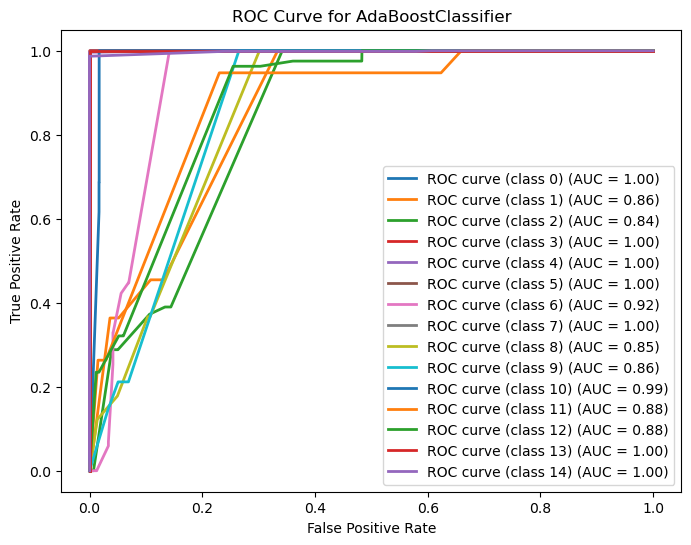

In [16]:
# Function to dislay f1 score and confusion matrix
def test_metrics(model,model_name,test_df=None):

    # Define score dictionary
    score_dict = {'Model Name':model_name,
                  'Train Score': f1_score(y_train,model.predict(X_train),average='weighted'),
                  'Test Score': f1_score(y_test, model.predict(X_test),average='weighted')}
    score_df=pd.DataFrame(score_dict,columns=['Model Name','Train Score','Test Score'],index=range(1))

    # Return new dataframe or concat 
    if test_df is None:
        pass
    else:
       score_df = pd.concat([test_df,score_df])
       score_df.index = range(len(score_df))
       score_df.sort_values(by='Test Score', inplace=True, ascending=False)

    # Display the dataframe
    display(score_df)
    
    # Get probabilities of each class
    y_proba = model.predict_proba(X_test)
    
    # Compute ROC curve and ROC area for each class
    plt.figure(figsize=(8, 6))
    lw = 2
    for i in range(len(set(y_test))):
        fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=lw, label=f'ROC curve (class {i}) (AUC = {roc_auc:.2f})')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve on Test for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    return score_df
    

# Predict on the test
test_scores = test_metrics(mnb_best,'MultiNB')

### Complement Naive Bayes

Since we know we have class imblance, lets see if this modification to Multinomial Naive Bayes can help improve our score for this model.

In [17]:
# Replace in pipeline

cnb_pipe = init_pipe.set_params(model=ComplementNB())
cnb_pipe.fit(X_train,y_train)

Pipeline(steps=[('txtproc', TextPreprocessor()),
                ('tfid', TfidfVectorizer(max_df=0.98, min_df=0.03)),
                ('model', ComplementNB())])

In [18]:
# Randomizedsearch CV 

params_cnb = {'model__alpha': [0.1, 1.0, 10.0],
              'model__force_alpha':[True,False],
              'model__fit_prior': [True,False]
    
}

rcv_cnb = RandomizedSearchCV(cnb_pipe,param_distributions=params_cnb,scoring='f1_weighted',
                        return_train_score=True,random_state=42,n_iter=12)

rcv_cnb.fit(X_train,y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('txtproc', TextPreprocessor()),
                                             ('tfid',
                                              TfidfVectorizer(max_df=0.98,
                                                              min_df=0.03)),
                                             ('model', ComplementNB())]),
                   n_iter=12,
                   param_distributions={'model__alpha': [0.1, 1.0, 10.0],
                                        'model__fit_prior': [True, False],
                                        'model__force_alpha': [True, False]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted')

In [19]:
# Print parameters of best estimate
rcv_cnb.best_params_

{'model__force_alpha': True, 'model__fit_prior': True, 'model__alpha': 0.1}

Unfortunately, this version of Naive Bayes did even worse than our Multinomial model. This is demonstrated in the score and test set ROC Curve

,Model Name,Val Train Score,Val Test Score
0,MultiNB,0.772405,0.771928
1,ComplementNB,0.735281,0.733771


,Model Name,Train Score,Test Score
0,MultiNB,0.855172,0.853105
1,ComplementNB,0.733154,0.742919


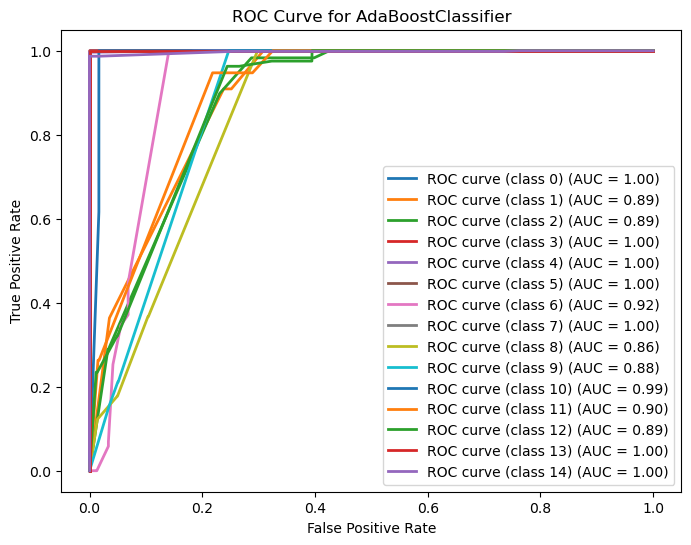

In [20]:
# Get train and test metrics
train_scores, cnb_best = rcv_metrics(rcv_cnb,'ComplementNB',train_scores)
display(train_scores)

test_scores = test_metrics(cnb_best,'ComplementNB',test_scores)

## 6. Tree Models

Next we will try some decision tree algorithms, starting with a simple `DecisionTreeClassifier`.

### Decision Tree

In [21]:
# Replace in pipeline

dec_pipe = init_pipe.set_params(model=DecisionTreeClassifier())
dec_pipe.fit(X_train,y_train)

Pipeline(steps=[('txtproc', TextPreprocessor()),
                ('tfid', TfidfVectorizer(max_df=0.98, min_df=0.03)),
                ('model', DecisionTreeClassifier())])

In [23]:
# Randomizedsearch CV 

params_dec = {'model__criterion': ['gini','entropy','log_loss'],
          'model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
          'model__min_samples_split': [2, 5, 10, 20, 50],
          'model__class_weight': [None,'balanced'],
          'model__min_samples_leaf': [1, 2, 5, 10]
}

rcv_dec = RandomizedSearchCV(dec_pipe,param_distributions=params_dec,scoring='f1_weighted',
                        return_train_score=True,random_state=42,n_iter=15)

rcv_dec.fit(X_train,y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('txtproc', TextPreprocessor()),
                                             ('tfid',
                                              TfidfVectorizer(max_df=0.98,
                                                              min_df=0.03)),
                                             ('model',
                                              DecisionTreeClassifier())]),
                   n_iter=15,
                   param_distributions={'model__class_weight': [None,
                                                                'balanced'],
                                        'model__criterion': ['gini', 'entropy',
                                                             'log_loss'],
                                        'model__max_depth': [3, 4, 5, 6, 7, 8,
                                                             9, 10],
                                        'model__min_samples_leaf': [1, 2, 5,
                                                                    10],
                                        'model__min_samples_split': [2, 5, 10,
                                                                     20, 50]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted')

In [24]:
# Print parameters of best estimate
rcv_dec.best_params_

{'model__min_samples_split': 5,
 'model__min_samples_leaf': 1,
 'model__max_depth': 8,
 'model__criterion': 'entropy',
 'model__class_weight': None}

So far, our decision tree is providin the best results on our unseen data!

,Model Name,Val Train Score,Val Test Score
0,MultiNB,0.772405,0.771928
1,ComplementNB,0.735281,0.733771
2,Decision,0.688695,0.688522


,Model Name,Train Score,Test Score
2,Decision,0.873223,0.873457
0,MultiNB,0.855172,0.853105
1,ComplementNB,0.733154,0.742919


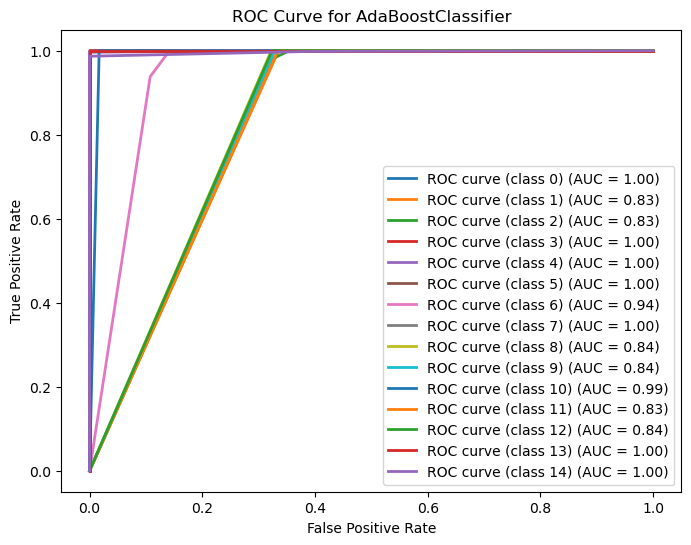

In [25]:
# Get train and test metrics
train_scores, dec_best = rcv_metrics(rcv_dec,'Decision',train_scores)
display(train_scores)

test_scores = test_metrics(dec_best,'Decision',test_scores)

### Random Forest

In [26]:
# Replace in pipeline

forest_pipe = init_pipe.set_params(model=RandomForestClassifier())
forest_pipe.fit(X_train,y_train)

Pipeline(steps=[('txtproc', TextPreprocessor()),
                ('tfid', TfidfVectorizer(max_df=0.98, min_df=0.03)),
                ('model', RandomForestClassifier())])

In [27]:
# Randomizedsearch CV 

params_forest = {'model__criterion': ['gini','entropy','log_loss'],
          'model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
          'model__min_samples_split': [2, 5, 10, 20, 50],
          'model__class_weight': ['balanced_subsample','balanced'],
          'model__max_features': ['sqrt','log2',None],
          'model__min_samples_leaf': [1, 2, 5, 10]
}

rcv_forest = RandomizedSearchCV(forest_pipe,param_distributions=params_forest,scoring='f1_weighted',
                        return_train_score=True,random_state=42,n_iter=15)

rcv_forest.fit(X_train,y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('txtproc', TextPreprocessor()),
                                             ('tfid',
                                              TfidfVectorizer(max_df=0.98,
                                                              min_df=0.03)),
                                             ('model',
                                              RandomForestClassifier())]),
                   n_iter=15,
                   param_distributions={'model__class_weight': ['balanced_subsample',
                                                                'balanced'],
                                        'model__criterion': ['gini', 'entropy',
                                                             'log_loss'],
                                        'model__max_depth': [3, 4, 5, 6, 7, 8,
                                                             9, 10],
                                        'model__max_features': ['sqrt', 'log2',
                                                                None],
                                        'model__min_samples_leaf': [1, 2, 5,
                                                                    10],
                                        'model__min_samples_split': [2, 5, 10,
                                                                     20, 50]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted')

In [28]:
# Print parameters of best estimate
rcv_forest.best_params_

{'model__min_samples_split': 50,
 'model__min_samples_leaf': 5,
 'model__max_features': 'log2',
 'model__max_depth': 8,
 'model__criterion': 'log_loss',
 'model__class_weight': 'balanced_subsample'}

The random forest performed worse than all models so far on unseen data and validation data. This could be due to a fairly small dataset and class imbalance.

Though, it looks like our ROC curve on par with our `MultiNomialNB` model

,Model Name,Val Train Score,Val Test Score
0,MultiNB,0.772405,0.771928
1,ComplementNB,0.735281,0.733771
2,Decision,0.688695,0.688522
3,Forest,0.693259,0.693077


,Model Name,Train Score,Test Score
0,Decision,0.873223,0.873457
1,MultiNB,0.855172,0.853105
3,Forest,0.749046,0.757757
2,ComplementNB,0.733154,0.742919


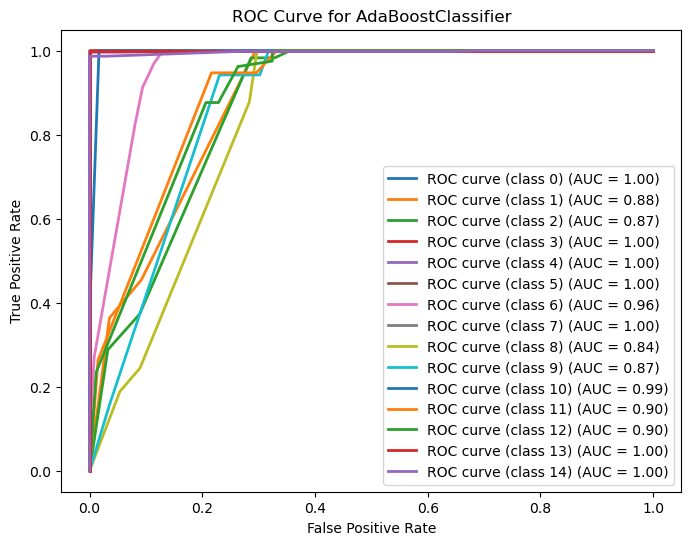

In [29]:
# Get train and test metrics
train_scores, forest_best = rcv_metrics(rcv_forest,'Forest',train_scores)
display(train_scores)

test_scores = test_metrics(forest_best,'Forest',test_scores)

## 7. Boosting Models

Since cost sensitive learning could help us with or class imbalance, we should try some models to see if we can get our score higher.

### Gradient Boost

In [30]:
# Replace in pipeline

gb_pipe = init_pipe.set_params(model=GradientBoostingClassifier())
gb_pipe.fit(X_train,y_train)

Pipeline(steps=[('txtproc', TextPreprocessor()),
                ('tfid', TfidfVectorizer(max_df=0.98, min_df=0.03)),
                ('model', GradientBoostingClassifier())])

In [31]:
# Randomizedsearch CV 

params_gb = {'model__max_depth': [3, 4, 6, 8, 10],
          'model__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
          'model__n_estimators': [100, 200, 500, 1000],
          'model__min_samples_split':  [2, 5, 10, 20, 50],
          'model__max_features': ['sqrt','log2',None],
          'model__subsample': [0.5, 0.75, 1.0],
          'model__min_samples_leaf': [1, 2, 5, 10]
          
}

rcv_gb = RandomizedSearchCV(gb_pipe,param_distributions=params_gb,scoring='f1_weighted',
                        return_train_score=True,random_state=42,n_iter=15)

rcv_gb.fit(X_train,y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('txtproc', TextPreprocessor()),
                                             ('tfid',
                                              TfidfVectorizer(max_df=0.98,
                                                              min_df=0.03)),
                                             ('model',
                                              GradientBoostingClassifier())]),
                   n_iter=15,
                   param_distributions={'model__learning_rate': [0.01, 0.05,
                                                                 0.1, 0.2,
                                                                 0.3],
                                        'model__max_depth': [3, 4, 6, 8, 10],
                                        'model__max_features': ['sqrt', 'log2',
                                                                None],
                                        'model__min_samples_leaf': [1, 2, 5,
                                                                    10],
                                        'model__min_samples_split': [2, 5, 10,
                                                                     20, 50],
                                        'model__n_estimators': [100, 200, 500,
                                                                1000],
                                        'model__subsample': [0.5, 0.75, 1.0]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted')

In [32]:
# Print parameters of best estimate
rcv_gb.best_params_

{'model__subsample': 0.5,
 'model__n_estimators': 500,
 'model__min_samples_split': 20,
 'model__min_samples_leaf': 5,
 'model__max_features': 'log2',
 'model__max_depth': 4,
 'model__learning_rate': 0.1}

When looking at our full train and test, the GradientBoost looks to have performed just about as well as our decision tree. 

,Model Name,Val Train Score,Val Test Score
0,MultiNB,0.772405,0.771928
1,ComplementNB,0.735281,0.733771
2,Decision,0.688695,0.688522
3,Forest,0.693259,0.693077
4,GradientBoost,0.740290,0.740090


,Model Name,Train Score,Test Score
0,Decision,0.873223,0.873457
4,GradientBoost,0.872656,0.871478
1,MultiNB,0.855172,0.853105
2,Forest,0.749046,0.757757
3,ComplementNB,0.733154,0.742919


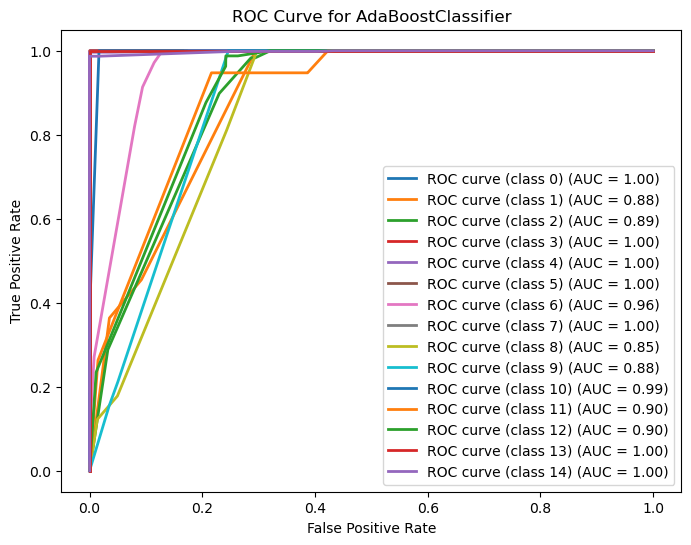

In [33]:
# Get train and test metrics
train_scores, gb_best = rcv_metrics(rcv_gb,'GradientBoost',train_scores)
display(train_scores)

test_scores = test_metrics(gb_best,'GradientBoost',test_scores)

### XGBoost

In [34]:
# Replace in pipeline

xgb_pipe = init_pipe.set_params(model=XGBClassifier())
xgb_pipe.fit(X_train,y_train)

Pipeline(steps=[('txtproc', TextPreprocessor()),
                ('tfid', TfidfVectorizer(max_df=0.98, min_df=0.03)),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_pol...one,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [35]:
# Randomizedsearch CV 

params_xgb = {'model__learning_rate':  [0.01, 0.05, 0.1, 0.3, 0.5],
          'model__n_estimators': [100, 500, 1000, 2000, 3000],
          'model__min_child_weight':  [1,5,10,20,50],
          'model__colsample_bytree': [0.5, 0.75, 1.0],
          'model__subsample': [0.5, 0.75, 1.0],
          'model__gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
          'model__reg_alpha':  [0, 0.001, 0.01, 0.1, 1, 10],
          'model__reg_lambda':  [0, 0.001, 0.01, 0.1, 1, 10],
          'model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10]
}

rcv_xgb = RandomizedSearchCV(xgb_pipe,param_distributions=params_xgb,scoring='f1_weighted',
                        return_train_score=True,random_state=42,n_iter=10)

rcv_xgb.fit(X_train,y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('txtproc', TextPreprocessor()),
                                             ('tfid',
                                              TfidfVectorizer(max_df=0.98,
                                                              min_df=0.03)),
                                             ('model',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_t...
                                        'model__learning_rate': [0.01, 0.05,
                                                                 0.1, 0.3,
                                                                 0.5],
                                        'model__max_depth': [3, 4, 5, 6, 7, 8,
                                                             9, 10],
                                        'model__min_child_weight': [1, 5, 10,
                                                                    20, 50],
                                        'model__n_estimators': [100, 500, 1000,
                                                                2000, 3000],
                                        'model__reg_alpha': [0, 0.001, 0.01,
                                                             0.1, 1, 10],
                                        'model__reg_lambda': [0, 0.001, 0.01,
                                                              0.1, 1, 10],
                                        'model__subsample': [0.5, 0.75, 1.0]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted')

In [36]:
# Print parameters of best estimate
rcv_xgb.best_params_

{'model__subsample': 0.5,
 'model__reg_lambda': 1,
 'model__reg_alpha': 0.01,
 'model__n_estimators': 3000,
 'model__min_child_weight': 1,
 'model__max_depth': 10,
 'model__learning_rate': 0.3,
 'model__gamma': 0,
 'model__colsample_bytree': 0.75}

,Model Name,Val Train Score,Val Test Score
0,MultiNB,0.772405,0.771928
1,ComplementNB,0.735281,0.733771
2,Decision,0.688695,0.688522
3,Forest,0.693259,0.693077
4,GradientBoost,0.740290,0.740090
5,XGBoost,0.864209,0.864116


,Model Name,Train Score,Test Score
0,Decision,0.873223,0.873457
1,GradientBoost,0.872656,0.871478
5,XGBoost,0.872656,0.871117
2,MultiNB,0.855172,0.853105
3,Forest,0.749046,0.757757
4,ComplementNB,0.733154,0.742919


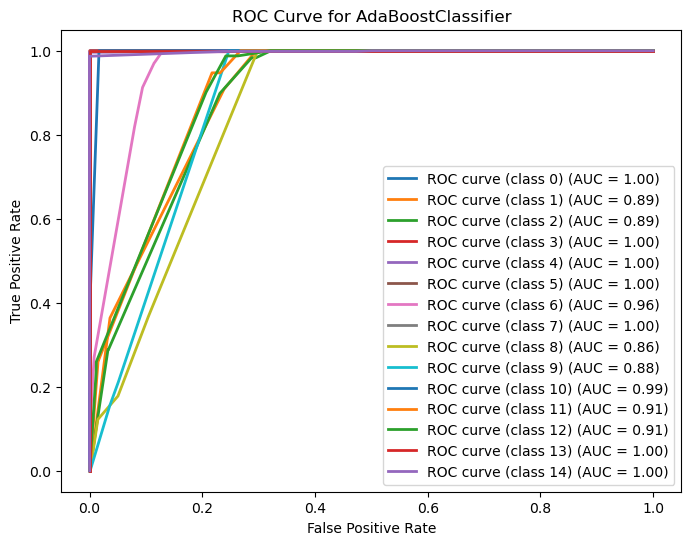

In [37]:
# Get train and test metrics
train_scores, xgb_best = rcv_metrics(rcv_xgb,'XGBoost',train_scores)
display(train_scores)

test_scores = test_metrics(xgb_best,'XGBoost',test_scores)

### AdaBoost

In [39]:
# Replace in pipeline

ada_pipe = init_pipe.set_params(model=AdaBoostClassifier(algorithm='SAMME'))
ada_pipe.fit(X_train,y_train)

Pipeline(steps=[('txtproc', TextPreprocessor()),
                ('tfid', TfidfVectorizer(max_df=0.98, min_df=0.03)),
                ('model', AdaBoostClassifier(algorithm='SAMME'))])

In [40]:
# Randomizedsearch CV 

params_ada = {'model__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
          'model__n_estimators': [50, 100, 200, 500, 1000]
}

rcv_ada = RandomizedSearchCV(ada_pipe,param_distributions=params_ada,scoring='f1_weighted',
                        return_train_score=True,random_state=42,n_iter=15)

rcv_ada.fit(X_train,y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('txtproc', TextPreprocessor()),
                                             ('tfid',
                                              TfidfVectorizer(max_df=0.98,
                                                              min_df=0.03)),
                                             ('model',
                                              AdaBoostClassifier(algorithm='SAMME'))]),
                   n_iter=15,
                   param_distributions={'model__learning_rate': [0.01, 0.05,
                                                                 0.1, 0.2,
                                                                 0.3],
                                        'model__n_estimators': [50, 100, 200,
                                                                500, 1000]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted')

In [41]:
# Print parameters of best estimate
rcv_ada.best_params_

{'model__n_estimators': 500, 'model__learning_rate': 0.3}

,Model Name,Val Train Score,Val Test Score
0,MultiNB,0.772405,0.771928
1,ComplementNB,0.735281,0.733771
2,Decision,0.688695,0.688522
3,Forest,0.693259,0.693077
4,GradientBoost,0.740290,0.740090
5,XGBoost,0.864209,0.864116
6,AdaBoost,0.468588,0.468614


,Model Name,Train Score,Test Score
0,Decision,0.873223,0.873457
6,AdaBoost,0.872402,0.873213
1,GradientBoost,0.872656,0.871478
2,XGBoost,0.872656,0.871117
3,MultiNB,0.855172,0.853105
4,Forest,0.749046,0.757757
5,ComplementNB,0.733154,0.742919


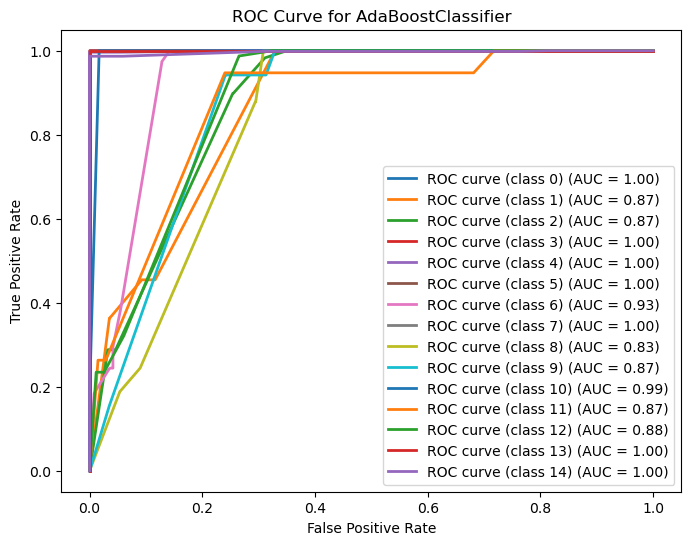

In [42]:
# Get train and test metrics
train_scores, ada_best = rcv_metrics(rcv_ada,'AdaBoost',train_scores)
display(train_scores)

test_scores = test_metrics(ada_best,'AdaBoost',test_scores)

## 8. Voting Classifier

### Average

In [108]:
# Create weighted averaging 

estimators = [
    ('gb',gb_best['model']),
    ('xgb',xgb_best['model']),
    ('ada',ada_best['model'])
]

voting_model =VotingClassifier(estimators=estimators)

voting_model.fit(X_train_trans,y_train)

VotingClassifier(estimators=[('gb',
                              GradientBoostingClassifier(max_depth=4,
                                                         max_features='log2',
                                                         min_samples_leaf=5,
                                                         min_samples_split=20,
                                                         n_estimators=500,
                                                         subsample=0.5)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.75, device=None,
                                            early_stopping_rounds=None,
                                            enable_categ...
                                            learning_rate=0.3, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=3000, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...)),
                             ('ada',
                              AdaBoostClassifier(algorithm='SAMME',
                                                 learning_rate=0.3,
                                                 n_estimators=500))])

In [ ]:
# Randomizedsearch CV 

params_voting = {'model__voting': ['hard','soft']
}

rcv_voting = RandomizedSearchCV(voting_model,param_distributions=params_voting,
                                scoring='f1_weighted', return_train_score=True,
                                random_state=42,n_iter=2,verbose=3)

rcv_voting.fit(X_train,y_train)

In [ ]:
# Print parameters of best estimate
rcv_voting.best_params_

In [ ]:
# Get train and test metrics
train_scores, voting_best = rcv_metrics(rcv_voting,'Voting',train_scores)
display(train_scores)

test_scores = test_metrics(voting_best,'Voting',test_scores)

### Weighted Average

In [ ]:
# Create weighted averaging 

estimators = [
    ('gb',gb_best['model']),
    ('xgb',xgb_best['model']),
    ('ada',ada_best['model'])
]

vot_w_model = VotingRegressor(estimators=estimators, weights=[.35,.2,.45]))

vot_w_model.fit(X_train_trans,y_train)

In [ ]:
# Randomizedsearch CV 

params_vot_w = {'model__weights': [[.2,.35,.45],[.2,.4,.4],[.1,.45,.45], [.1,.40,.50]]
}

rcv_vot_w = RandomizedSearchCV(vot_w_model,param_distributions=params_vot_w,
                                scoring='f1_weighted', return_train_score=True,
                                random_state=42,n_iter=2,verbose=3)

rcv_voting.fit(X_train,y_train)

In [ ]:
# Get train and test metrics
train_scores, voting_best = rcv_metrics(rcv_vot_w,'Voting',train_scores)
display(train_scores)

test_scores = test_metrics(vot_w_best,'Voting',test_scores)

## Best Model Comparison

In [66]:
print('DecisionTree Classification Report\n',classification_report(y_test,dec_best.predict(X_test),
                                                                   zero_division=1))
print('AdaBoost Classification Report\n',classification_report(y_test,gb_best.predict(X_test),
                                                                    zero_division=1))

DecisionTree Classification Report
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       182
           1       1.00      0.00      0.00        11
           2       1.00      0.00      0.00        59
           3       0.99      1.00      1.00       163
           4       1.00      1.00      1.00       280
           5       1.00      1.00      1.00       272
           6       0.77      0.94      0.85      1134
           7       1.00      1.00      1.00       362
           8       1.00      0.00      0.00        90
           9       1.00      0.00      0.00        52
          10       0.59      1.00      0.74        99
          11       1.00      0.00      0.00        19
          12       1.00      0.00      0.00        81
          13       1.00      1.00      1.00       687
          14       1.00      0.99      0.99       611

    accuracy                           0.90      4102
   macro avg       0.96      0.59      0.57 

symptoms      0.243201
treatments    0.208614
be            0.140731
many          0.113919
change        0.107509
cause         0.077688
diagnose      0.071039
do            0.035366
type          0.001934
people        0.000000
dtype: float64

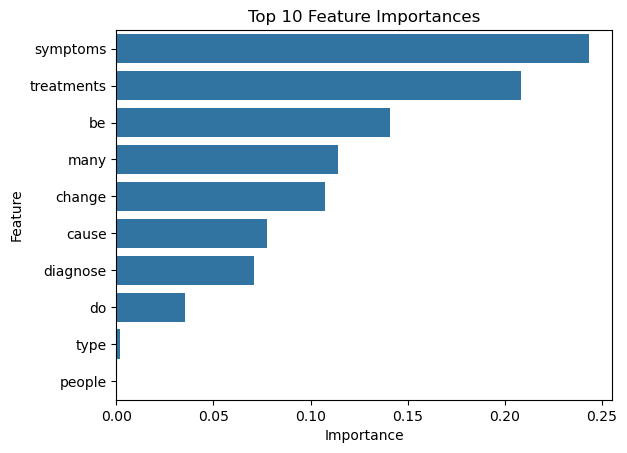

In [101]:
# Define feature importances
feature_importances = dec_best['model'].feature_importances_
feature_importances = ada_best['model'].feature_importances_

# Define and Display full series with feature importance
dec_feat_imp = pd.Series(feature_importances,dec_best['tfid'].get_feature_names_out())
ada_feat_imp = pd.Series(feature_importances,ada_best['tfid'].get_feature_names_out())

# Get top 10 features
dec_feat10 = dec_feat_imp.sort_values(ascending=False).nlargest(10)
ada_feat10 = ada_feat_imp.sort_values(ascending=False).nlargest(10)

print('DecisionTree Top 10 Features')
display(dec_feat10)

print('AdaBoost Top 10 Features')
display(ada_feat10)



sns.barplot(x=dec_feat10.values,y=dec_feat10.index)
plt.title("Top 10 Feature Importances (dec_best)")
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

diagnose      0.138571
be            0.138037
cause         0.135887
do            0.119973
change        0.118109
symptoms      0.087105
many          0.086476
treatments    0.077617
cancer        0.028790
relate        0.026965
dtype: float64

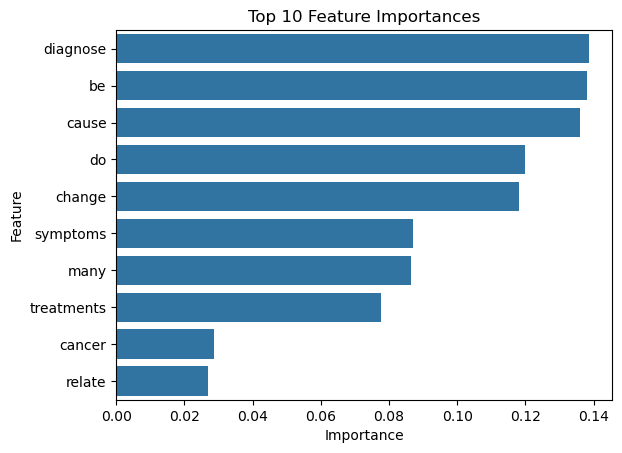

In [102]:
# Define feature importances
feature_importances = ada_best['model'].feature_importances_

# Define and Display full series with feature importance
ada_feat_imp = pd.Series(feature_importances,ada_best['tfid'].get_feature_names_out())

ada_feat10 = ada_feat_imp.sort_values(ascending=False).nlargest(10)
display(ada_feat10)


sns.barplot(x=ada_feat10.values,y=ada_feat10.index)
plt.title("Top 10 Feature Importances")
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()